<b>Hyperparameters</b>: 
<br><b>win_tol</b>: window tolerance within which if a method detected cp, count that as true changepoint detected
<br>win_tol=2
<br>For BOCD: <b>run_length_threshold</b> - the change in run_length that constitutes a changepoint, for example if run_length_threshold is set to 4, then if run length drops by 4 or more, then that constitutes a changepoint
<br>For gradient based: <b>gradient_threshold</b>: the threshold above which a change in gradient constitutes a changepoint.
<br>For MC_dropout: <b>mc_dropout_threshold</b>: the threshold above which a change in variance in any of the output dimensions constitutes a changepoint
<br>
<br> <b>If TP=FP=0, Precision=1 rather than 0 and if TP=FN=0, then Recall=1 rather than 0 
<br> zero division is taken as 1 and not 0 for Precision and Recall</b>
<br> example: true_cps = [3, 31, 250, 273], pred_cps = [30, 31, 249, 250, 272, 300]
<br> TP = 3, FP = 1, FN = 1, TN = 317-5 = 312
<br> true changepoint 3 could not be detected but the rest were detected within the window tolerance
<br> false changepoint 300 was detected
<br>
<br>Precision = TP/(TP+FP)
<br>Recall or A_cp = TP/(TP+FN)
<br>A_cp = Accuracy for detecting changepoints (minority class)
<br>Accuracy = (TP+TN)/(TP+TN+FP+FN)
<br>A_major or A_no_cp = TN/(TN+FP)
<br>A_major or A_no_cp = Accuracy for detecting points that are not changepoints (majority class)
<br>Balanced_Accuracy = 1/2*(A_cp+A_major)

In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from   matplotlib.colors import LogNorm
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics

In [2]:
root_dir = "/home/users/richras/Ge2Net_Repo"
os.chdir(root_dir)

In [3]:
!./ini.sh

set environment variables
All done


In [4]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [5]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows
from src.utils.modelUtil import Params, load_model
from src.utils.decorators import timer
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred
from src.main.settings_model import parse_args, MODEL_CLASS
import test

# load the model and use valid data to choose hyperpparams for the different cp methods

In [6]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_3_pca')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_3_pca')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_B_exp_id_7_data_id_3_pca/') 
dataset_type='valid'

In [7]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
results, valid_dataset=test.main(config, params)

 device used: cuda
Loading the datasets...
Finished 'transform_data' in 28.4517 secs
Finished '__init__' in 34.5487 secs
model ['Model_B.model_B'] : AuxiliaryTask.AuxNetwork
model ['Model_B.model_B'] : LSTM.BiRNN
model ['Model_B.model_B'] : BasicBlock.logits_Block
best val loss metrics : {'gcd': None, 'mse': 0.2178936406499827, 'smooth_l1': 0.10351521903088674, 'weighted_loss': 0.3591735236903656, 'loss_main': 0.3591735236903656, 'loss_aux': 0.8821184329220864}
at epoch : 87
train loss metrics: {'gcd': None, 'mse': 0.10320528280809713, 'smooth_l1': 0.04959562086833885, 'weighted_loss': 0.2486219141212711, 'loss_main': 0.2296785485357874, 'loss_aux': 0.9173492295086926}
best val cp metrics : {'loss_cp': 0.07215550060296119, 'Precision': 0.9114085290660635, 'Recall': 0.649776802320253, 'Accuracy': 0.9908863056911974, 'A_major': 0.9988673499663322, 'BalancedAccuracy': 0.8243220761432926}
train cp metrics: {'loss_cp': 0.20510284079111923, 'Precision': 0.022963283535932782, 'Recall': 0.9664

In [8]:
results.t_accr, results.t_cp_accr

({'gcd': None,
  'loss_aux': 0.9119396815986777,
  'loss_main': 0.3461540393673566,
  'mse': 0.18840505032328983,
  'smooth_l1': 0.09020874936023994,
  'weighted_loss': 0.3461540393673566},
 {'A_major': 0.7089408377137135,
  'Accuracy': 0.7101637785748239,
  'BalancedAccuracy': 0.8230871556208538,
  'Precision': 0.021366197100880738,
  'Recall': 0.937233473527994,
  'loss_cp': 0.20465141559150965})

In [9]:
@timer
def prMetricsByThresh(method_name, cp_pred_raw, cp_target, steps, minThresh, maxThresh, win_tol=2, byWindows=False):
    increment = (maxThresh - minThresh)/steps
    df=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
    for thresh in np.arange(minThresh, maxThresh + increment, increment):
        prMetrics, cp_pred = reportChangePointMetrics(method_name, cp_pred_raw, cp_target, thresh, win_tol)
        if byWindows: 
            prMetrics={}
            prMetrics['Precision']=precision_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Recall']=recall_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['BalancedAccuracy']=balanced_accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Accuracy']=accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['A_major']=(2*prMetrics['BalancedAccuracy'])-prMetrics['Recall']
        prMetrics['thresh']=thresh
        prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
        df=df.append(prMetrics, ignore_index=True)
    return df

# neural network, choose the threshold for logits

In [10]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0.4, 0.5)
df_nn.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 17.9502 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.021336,0.938091,0.709356,0.708113,0.823102,0.400000,0.041724
1,0.021339,0.938091,0.709380,0.708137,0.823114,0.405000,0.041729
2,0.021333,0.937975,0.709394,0.708154,0.823065,0.410000,0.041717
3,0.021329,0.937854,0.709415,0.708178,0.823016,0.415000,0.041710
4,0.021329,0.937785,0.709446,0.708209,0.822997,0.420000,0.041709
5,0.021327,0.937707,0.709483,0.708248,0.822978,0.425000,0.041706
6,0.021331,0.937707,0.709535,0.708300,0.823004,0.430000,0.041714
7,0.021332,0.937539,0.709606,0.708375,0.822957,0.435000,0.041715
8,0.021333,0.937380,0.709696,0.708468,0.822924,0.440000,0.041716
9,0.021345,0.937288,0.709866,0.708640,0.822964,0.445000,0.041739


In [11]:
nnThresh=0.455

# gradient method, choose the threshold for gradient difference in predictions

In [12]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,1)
df_grad.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 9.1309 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.007360,1.000000,0.036458,0.030035,0.515017,0.000000,0.014612
1,0.181647,0.868860,0.952505,0.953578,0.911219,0.050000,0.300476
2,0.406363,0.843936,0.978609,0.980243,0.912089,0.100000,0.548579
3,0.519962,0.825680,0.986490,0.988422,0.907051,0.150000,0.638093
4,0.616492,0.809002,0.990187,0.992341,0.900671,0.200000,0.699748
5,0.701802,0.796062,0.992365,0.994692,0.895377,0.250000,0.745967
6,0.753902,0.785613,0.993629,0.996103,0.890858,0.300000,0.769431
7,0.793192,0.775167,0.994400,0.997011,0.886089,0.350000,0.784076
8,0.822036,0.766072,0.994916,0.997653,0.881863,0.400000,0.793068
9,0.841695,0.754351,0.995256,0.998128,0.876239,0.450000,0.795633


In [13]:
gradThresh=0.5

# mc dropout variance, choose the threshold for difference in variance

In [14]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,0.5)
df_var.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 9.3062 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.007335,1.000000,0.033319,0.026874,0.513437,0.000000,0.014563
1,0.359634,0.825548,0.889467,0.890469,0.858008,0.025000,0.501012
2,0.430133,0.756694,0.932110,0.934266,0.845480,0.050000,0.548486
3,0.479545,0.691663,0.949623,0.952695,0.822179,0.075000,0.566395
4,0.522339,0.630189,0.959826,0.963675,0.796932,0.100000,0.571218
5,0.555172,0.584852,0.966659,0.971088,0.777970,0.125000,0.569626
6,0.583650,0.541147,0.971425,0.976395,0.758771,0.150000,0.561595
7,0.608366,0.509473,0.975202,0.980576,0.745025,0.175000,0.554545
8,0.641437,0.486312,0.978285,0.983974,0.735143,0.200000,0.553206
9,0.670786,0.468511,0.980586,0.986502,0.727507,0.225000,0.551693


In [15]:
varThresh=0.10

# BOCD, Compute the run lengths and changepoints by using a multivariate Gaussian (with independent three dimensions of predictions) to model the prediction sequence

In [16]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
posterior, _, predictive, e_mean = model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 190.4977 secs


In [17]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20,0,10)
df_bocd.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 14.3574 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,1.000000,0.404384,0.993123,1.000000,0.702192,0.000000,0.575888
1,1.000000,0.404384,0.993123,1.000000,0.702192,0.500000,0.575888
2,0.773262,0.704926,0.995042,0.998483,0.851704,1.000000,0.737515
3,0.773262,0.704926,0.995042,0.998483,0.851704,1.500000,0.737515
4,0.666601,0.777340,0.994229,0.996832,0.887086,2.000000,0.717724
5,0.666601,0.777340,0.994229,0.996832,0.887086,2.500000,0.717724
6,0.622591,0.795767,0.993453,0.995838,0.895802,3.000000,0.698607
7,0.622591,0.795767,0.993453,0.995838,0.895802,3.500000,0.698607
8,0.598913,0.801462,0.992913,0.995217,0.898340,4.000000,0.685539
9,0.598913,0.801462,0.992913,0.995217,0.898340,4.500000,0.685539


In [18]:
bocdThresh=2.0

# Summary Table with chosen thresholds

In [19]:
pd.options.display.float_format='{:,.4f}'.format
df_summary=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
cpThresh=[nnThresh, gradThresh, varThresh, bocdThresh]
cp_target=valid_dataset.data['cps']
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, cp_target, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary=df_summary.append(prMetrics, ignore_index=True)
df_summary

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.6728,0.7057,0.9924,0.9957,0.8507,0.4550,0.6889,neural_network
1,0.8622,0.7441,0.9955,0.9985,0.8713,0.5000,0.7988,gradient
2,0.5223,0.6302,0.9598,0.9637,0.7969,0.1000,0.5712,mc_dropout
3,0.6666,0.7773,0.9942,0.9968,0.8871,2.0000,0.7177,BOCD


plot of Precision/Recall

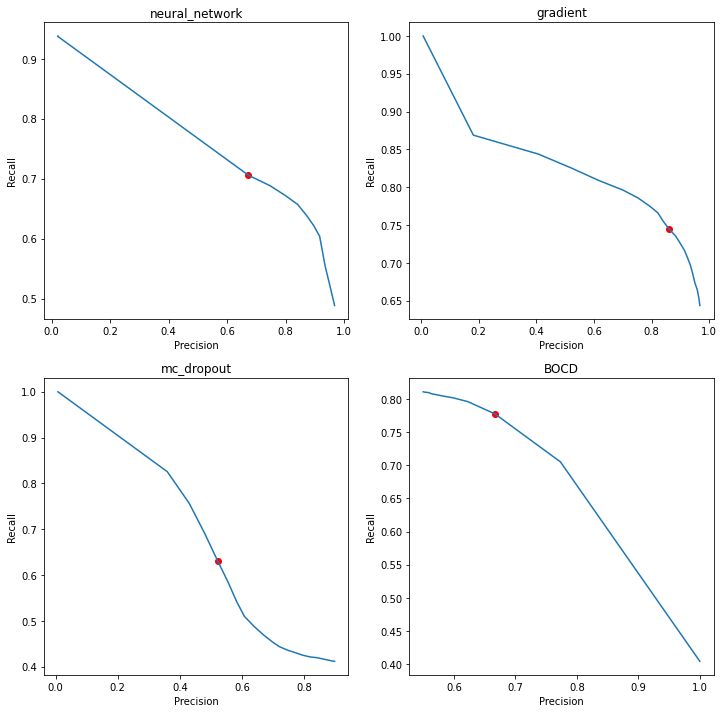

In [20]:
fig, ax = plt.subplots(2,2,figsize=[12,12])

for (row,col), df, name in zip(itertools.product([0,1],[0,1]),[df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    ax[row,col].plot(df['Precision'], df['Recall'])
    ax[row,col].set_xlabel('Precision')
    ax[row,col].set_ylabel('Recall')
    ax[row,col].set_title(name)
    df_row=df_summary[df_summary.Name==name]
    ax[row,col].scatter(df_row['Precision'], df_row['Recall'], color='r')
plt.show()

# Qualitative by looking at anecdotes/samples

In [21]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
cp_target=valid_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
pred_cps = {}
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    _, pred_cps[name]= reportChangePointMetrics(name, pred_raw, cp_target, thresh)

true_cps=cp_target.detach().cpu().numpy()
pred_cps={k:v.detach().cpu().numpy() for k,v in pred_cps.items()}

In [22]:
def plot_changepoints(true_cps, pred_cps, y_pred, bocp_rl, y_var, popNames):
    fig, ax = plt.subplots(8,1,figsize=[18,30])
    ax[0].plot(y_pred)
    ax[0].text(0, np.max(y_pred)-0.5, s=popNames[0], size=10)
    for i in np.nonzero(true_cps)[0]:
        ax[0].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
        ax[0].text(i, np.max(y_pred)-0.5, s=popNames[i+1], size=10)
    ax[1].plot(pred_cps[cpMethod.gradient.name])
    ax[2].plot(y_var)
    ax[3].plot(pred_cps[cpMethod.mc_dropout.name])
    ax[4].plot(pred_cps[cpMethod.neural_network.name])
    ax[5].plot(np.arange(T+1), bocp_rl)
    ax[6].plot(pred_cps[cpMethod.BOCD.name])
    ax[7].plot(true_cps)
    
    ax[0].set_title("n_vectors")
    ax[1].set_title("Simple gradient(post_process)")
    ax[2].set_title("Mc dropout variance")
    ax[3].set_title("Mc dropout")
    ax[4].set_title("Neural Network predicted cp")
    ax[5].set_title("BOCD (post process) run_length")
    ax[6].set_title("BOCD (post process) cp")
    ax[7].set_title("True Cps")
    plt.show()

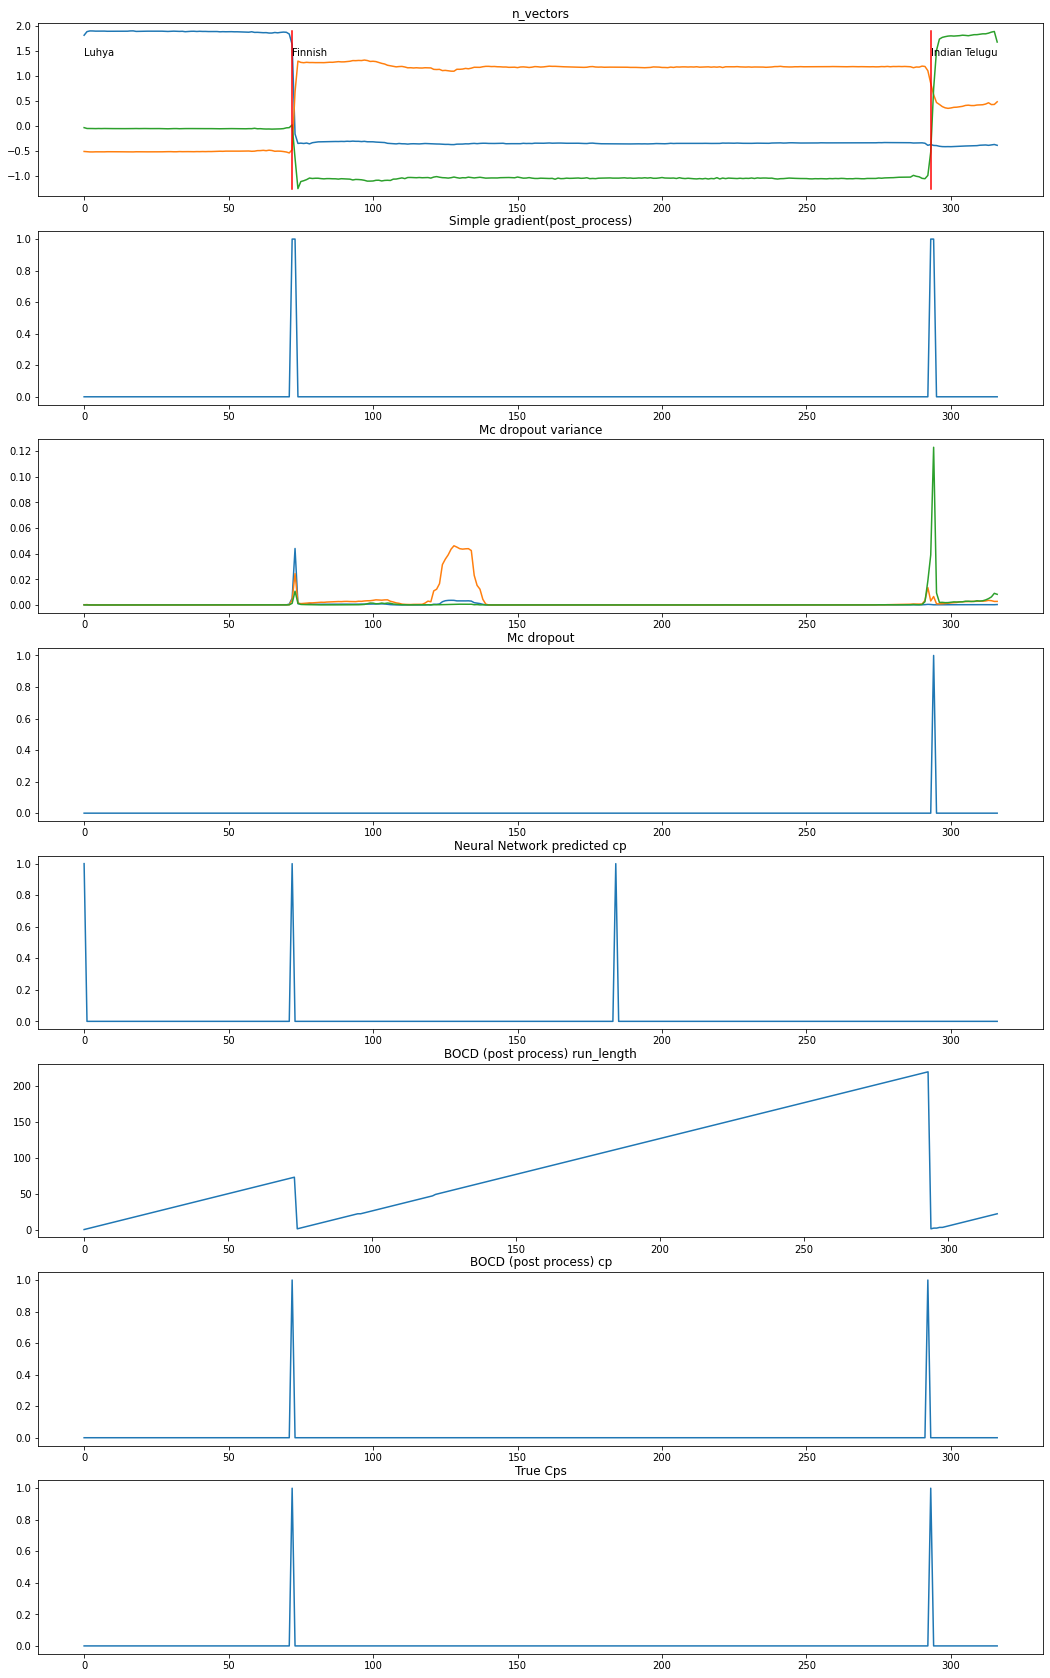

In [23]:
index = 2000
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:].detach().cpu().numpy()
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

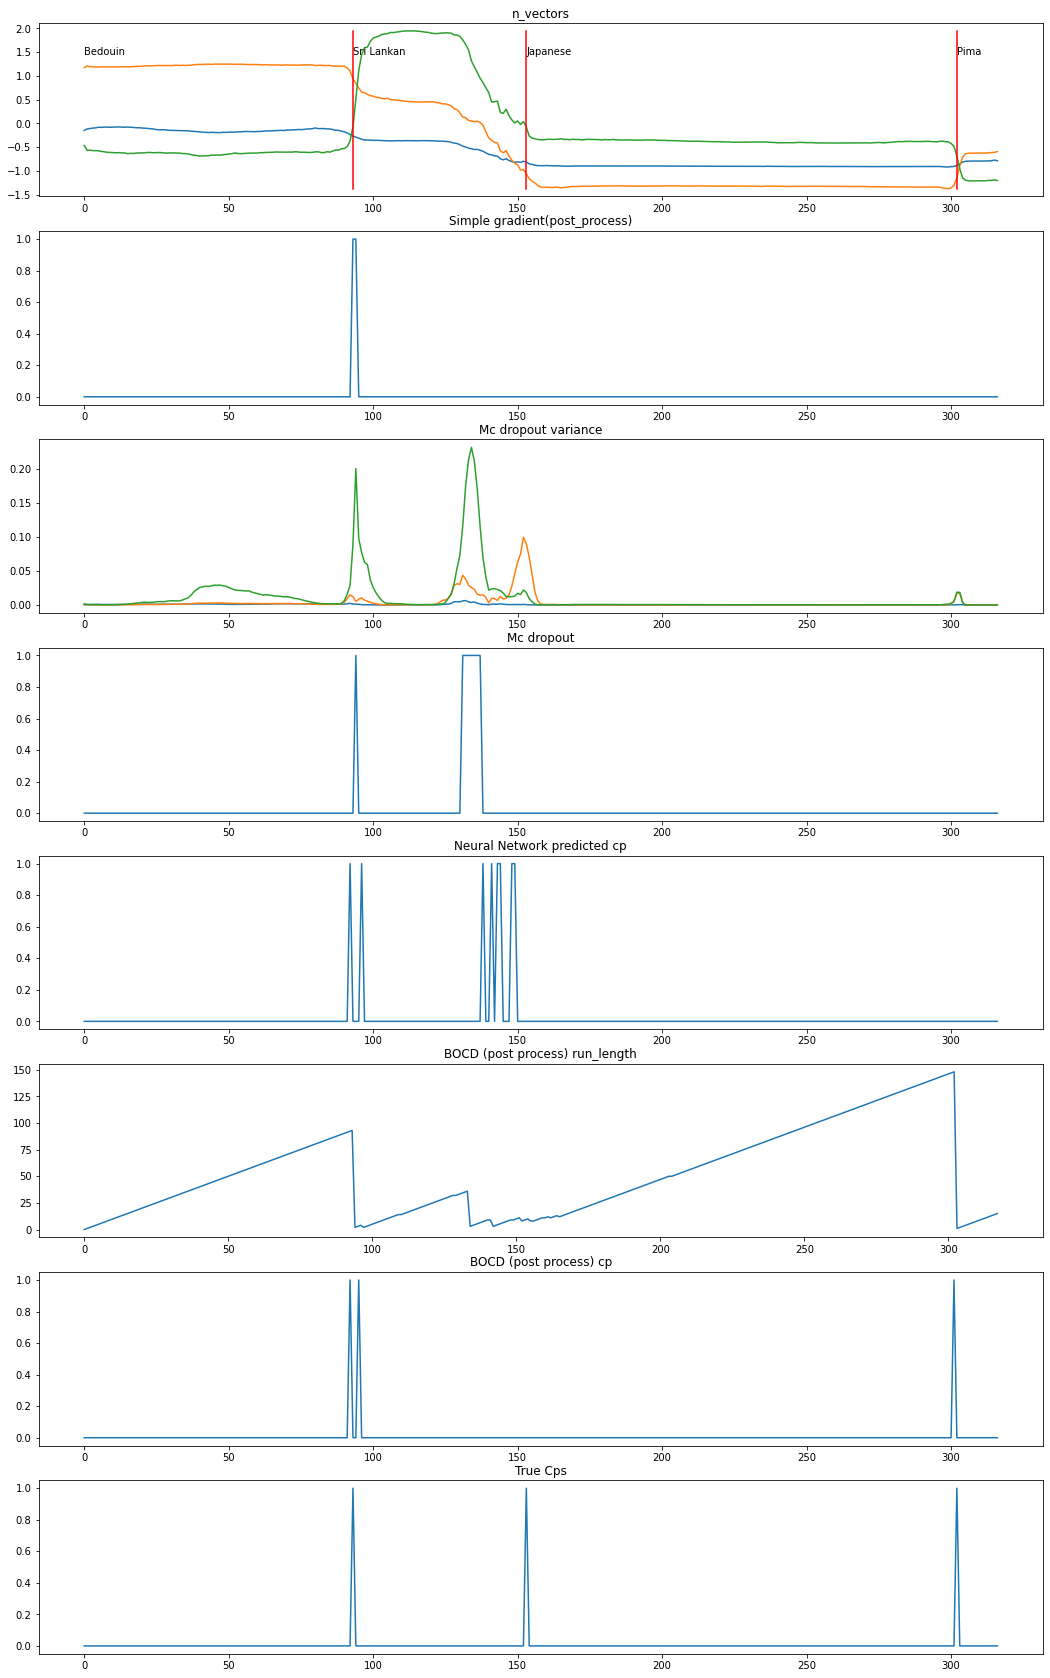

In [24]:
index = 2620
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:].detach().cpu().numpy()
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

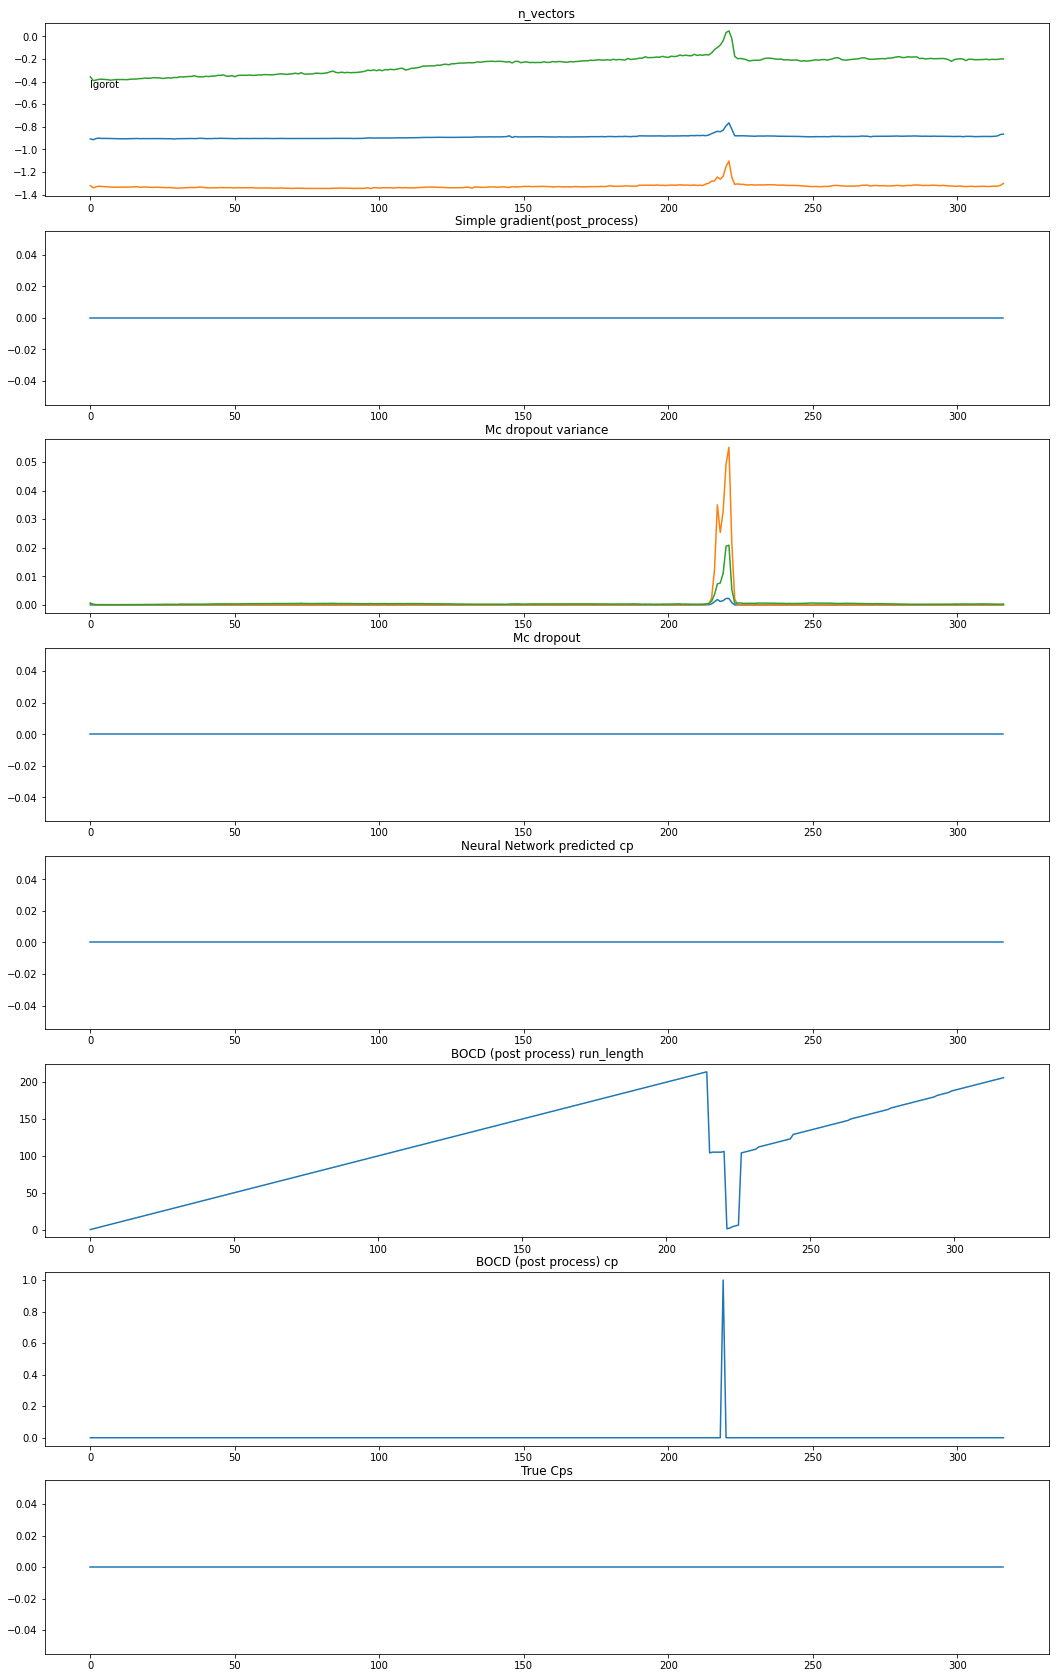

In [25]:
index = 1200
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results.t_out.coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=valid_dataset.data['granular_pop'][index,:].detach().cpu().numpy()
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

# evaluate on a subset of samples that have at least 1 changepoint 


In [26]:
subset_idx=torch.unique(torch.nonzero(valid_dataset.data['cps'])[:,0])

In [27]:
df_summary_subset=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
subsetSamples_trueCps=valid_dataset.data['cps'].unsqueeze(2)[subset_idx,:]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
             torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), 
             torch.tensor(results.t_out.y_var[subset_idx,:]).float(),\
             model_cpd.cp[subset_idx,:]]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, subsetSamples_trueCps, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary_subset=df_summary_subset.append(prMetrics, ignore_index=True)
df_summary_subset

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.6323,0.5059,0.9888,0.9944,0.7502,0.4550,0.5621,neural_network
1,0.8551,0.5704,0.9931,0.9982,0.7843,0.5000,0.6843,gradient
2,0.4184,0.3791,0.9502,0.9566,0.6679,0.1000,0.3978,mc_dropout
3,0.6919,0.6262,0.9919,0.9962,0.8112,2.0000,0.6574,BOCD


# compute metrics by placing win_tol=0

In [28]:
df_zero_tol=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
trueCps=valid_dataset.data['cps'].unsqueeze(2).float()
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), \
             torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(),\
             model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, trueCps, thresh, win_tol=0)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_zero_tol=df_zero_tol.append(prMetrics, ignore_index=True)
df_zero_tol

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.4777,0.6037,0.9867,0.9912,0.7975,0.4550,0.5334,neural_network
1,0.6440,0.6876,0.9912,0.9949,0.8412,0.5000,0.6651,gradient
2,0.4290,0.5163,0.9545,0.9596,0.7380,0.1000,0.4686,mc_dropout
3,0.4262,0.5503,0.9890,0.9941,0.7722,2.0000,0.4803,BOCD


# evaluate to make sure matches with scikit learn (subset with samples that have cp, and win_tol=0 for evaluation

In [29]:
df_summary_subset=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
subsetSamples_trueCps=valid_dataset.data['cps'].unsqueeze(2)[subset_idx,:]
cp_pred_raw=[torch.tensor(results.t_out.cp_logits[subset_idx,:]).float(), \
             torch.tensor(results.t_out.coord_main[subset_idx,:]).float(), 
             torch.tensor(results.t_out.y_var[subset_idx,:]).float(),\
             model_cpd.cp[subset_idx,:]]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, subsetSamples_trueCps, thresh, win_tol=0)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_summary_subset=df_summary_subset.append(prMetrics, ignore_index=True)
df_summary_subset

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.3049,0.3347,0.9792,0.9867,0.6607,0.4550,0.3191,neural_network
1,0.4888,0.4755,0.9860,0.9921,0.7338,0.5000,0.4821,gradient
2,0.2617,0.1879,0.9413,0.9499,0.5689,0.1000,0.2187,mc_dropout
3,0.2882,0.2449,0.9831,0.9916,0.6183,2.0000,0.2648,BOCD


# evaluate by Windows

In [30]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0.4, 0.5, byWindows=True)
df_nn.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 135.8594 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.012166,0.537891,0.696471,0.697569,0.617730,0.400000,0.023794
1,0.012142,0.536760,0.696500,0.697606,0.617183,0.405000,0.023747
2,0.012104,0.535001,0.696527,0.697645,0.616323,0.410000,0.023673
3,0.012075,0.533618,0.696564,0.697692,0.615655,0.415000,0.023616
4,0.012063,0.532990,0.696606,0.697739,0.615364,0.420000,0.023592
5,0.012035,0.531607,0.696663,0.697806,0.614707,0.425000,0.023537
6,0.012027,0.531105,0.696737,0.697884,0.614495,0.430000,0.023521
7,0.011991,0.529345,0.696818,0.697977,0.613661,0.435000,0.023451
8,0.011953,0.527460,0.696921,0.698094,0.612777,0.440000,0.023377
9,0.011921,0.525701,0.697100,0.698286,0.611994,0.445000,0.023314


In [31]:
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results.t_out.coord_main).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,1, byWindows=True)
df_grad.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 55.0327 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.006899,1.000000,0.010032,0.003176,0.501588,0.000000,0.013703
1,0.075174,0.724519,0.936808,0.938278,0.831399,0.050000,0.136214
2,0.127580,0.670479,0.966204,0.968251,0.819365,0.100000,0.214369
3,0.169210,0.632776,0.976109,0.978487,0.805631,0.150000,0.267017
4,0.205894,0.602363,0.981289,0.983913,0.793138,0.200000,0.306889
5,0.240552,0.575971,0.984579,0.987408,0.781690,0.250000,0.339368
6,0.271917,0.552344,0.986751,0.989759,0.771051,0.300000,0.364428
7,0.300975,0.527586,0.988325,0.991515,0.759550,0.350000,0.383291
8,0.327931,0.503456,0.989490,0.992855,0.748156,0.400000,0.397165
9,0.356805,0.483348,0.990455,0.993967,0.738657,0.450000,0.410547


In [32]:
df_var=prMetricsByThresh(cpMethod.mc_dropout.name, torch.tensor(results.t_out.y_var).float(), \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20, 0,0.5, byWindows=True)
df_var.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 54.8949 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.006877,1.000000,0.006877,0.000000,0.500000,0.000000,0.013660
1,0.029899,0.531733,0.878133,0.880532,0.706132,0.025000,0.056614
2,0.034711,0.377529,0.923520,0.927301,0.652415,0.050000,0.063577
3,0.035172,0.275983,0.942958,0.947576,0.611780,0.075000,0.062393
4,0.033229,0.199698,0.954540,0.959767,0.579733,0.100000,0.056977
5,0.031182,0.148548,0.962404,0.968040,0.558294,0.125000,0.051544
6,0.028053,0.108332,0.968056,0.974009,0.541171,0.150000,0.044565
7,0.026454,0.083449,0.972578,0.978735,0.531092,0.175000,0.040173
8,0.024626,0.063717,0.976206,0.982524,0.523121,0.200000,0.035523
9,0.022645,0.049013,0.978913,0.985352,0.517183,0.225000,0.030978


In [33]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        valid_dataset.data['cps'].unsqueeze(2).float(), 20,1,11, byWindows=True)
df_bocd.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 61.3388 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.283422,0.201961,0.991000,0.996464,0.599212,1.000000,0.235855
1,0.283422,0.201961,0.991000,0.996464,0.599212,1.500000,0.235855
2,0.226327,0.248712,0.988987,0.994113,0.621412,2.000000,0.236992
3,0.226327,0.248712,0.988987,0.994113,0.621412,2.500000,0.236992
4,0.200275,0.256127,0.987851,0.992918,0.624522,3.000000,0.224784
5,0.200275,0.256127,0.987851,0.992918,0.624522,3.500000,0.224784
6,0.187227,0.258640,0.987180,0.992225,0.625433,4.000000,0.217215
7,0.187227,0.258640,0.987180,0.992225,0.625433,4.500000,0.217215
8,0.178772,0.260148,0.986694,0.991725,0.625937,5.000000,0.211916
9,0.178772,0.260148,0.986694,0.991725,0.625937,5.500000,0.211916


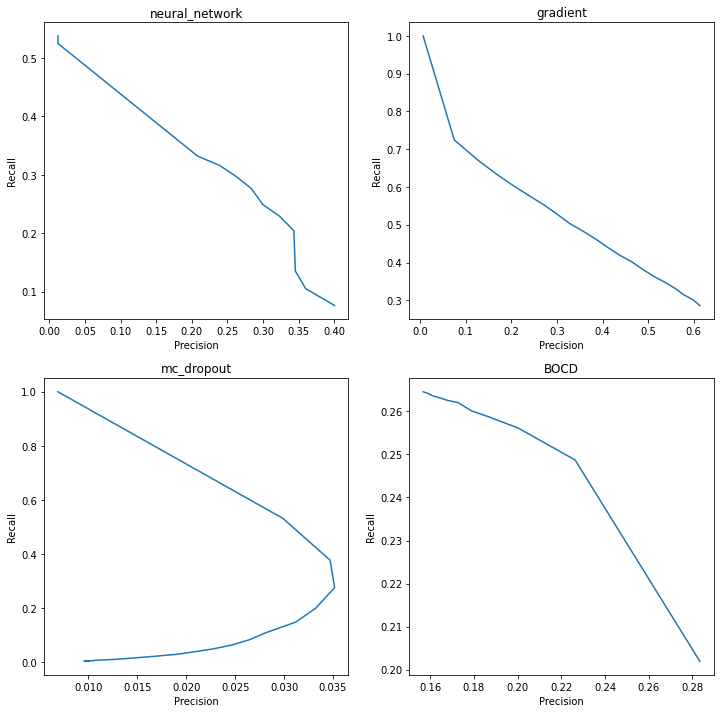

In [34]:
fig, ax = plt.subplots(2,2,figsize=[12,12])

for (row,col), df, name in zip(itertools.product([0,1],[0,1]),[df_nn, df_grad, df_var, df_bocd],[cp.name for cp in cpMethod]) :
    ax[row,col].plot(df['Precision'], df['Recall'])
    ax[row,col].set_xlabel('Precision')
    ax[row,col].set_ylabel('Recall')
    ax[row,col].set_title(name)
plt.show()

# load the model and evaluate with test data on the chosen hyperparameters

In [35]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_3_pca')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_3_pca')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_B_exp_id_7_data_id_3_pca/') 
dataset_type='test'

In [36]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=True
params.mc_samples=100
params.cp_tol=0
results, test_dataset=test.main(config, params)

 device used: cuda
Loading the datasets...
Finished 'transform_data' in 17.3982 secs
Finished '__init__' in 22.0398 secs
model ['Model_B.model_B'] : AuxiliaryTask.AuxNetwork
model ['Model_B.model_B'] : LSTM.BiRNN
model ['Model_B.model_B'] : BasicBlock.logits_Block
best val loss metrics : {'gcd': None, 'mse': 0.2178936406499827, 'smooth_l1': 0.10351521903088674, 'weighted_loss': 0.3591735236903656, 'loss_main': 0.3591735236903656, 'loss_aux': 0.8821184329220864}
at epoch : 87
train loss metrics: {'gcd': None, 'mse': 0.10320528280809713, 'smooth_l1': 0.04959562086833885, 'weighted_loss': 0.2486219141212711, 'loss_main': 0.2296785485357874, 'loss_aux': 0.9173492295086926}
best val cp metrics : {'loss_cp': 0.07215550060296119, 'Precision': 0.9114085290660635, 'Recall': 0.649776802320253, 'Accuracy': 0.9908863056911974, 'A_major': 0.9988673499663322, 'BalancedAccuracy': 0.8243220761432926}
train cp metrics: {'loss_cp': 0.20510284079111923, 'Precision': 0.022963283535932782, 'Recall': 0.9664

# Summary Table with test data

compute BOCD

In [37]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
test_tensor = torch.tensor(y_pred).float()
batch_size_cpd = test_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
posterior, _, predictive, e_mean = model_cpd.run_recursive(test_tensor, 'cpu')

Finished 'run_recursive' in 151.3760 secs


In [38]:
df_test=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
trueCps=test_dataset.data['cps'].unsqueeze(2).float()
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), \
             torch.tensor(results.t_out.coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(),\
             model_cpd.cp]
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    prMetrics, _= reportChangePointMetrics(name, pred_raw, trueCps, thresh, win_tol=2)
    prMetrics['thresh']=thresh
    prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
    prMetrics['Name']=name
    df_test=df_test.append(prMetrics, ignore_index=True)
df_test

,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1,Name
0,0.6704,0.6519,0.9917,0.9955,0.8237,0.4550,0.6610,neural_network
1,0.8687,0.7021,0.9951,0.9985,0.8503,0.5000,0.7765,gradient
2,0.4844,0.5581,0.9583,0.9629,0.7605,0.1000,0.5186,mc_dropout
3,0.6957,0.7318,0.9937,0.9967,0.8643,2.0000,0.7133,BOCD
